# TFM - Predicción potenciales compradores de un ecommerce

Evolución del notebook *Modelo_1.ipynb* unicamente aplicando a **personas Jurídicas**

------------------------------------

------------------

### 1.1 Librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import ParameterGrid

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, RUSBoostClassifier, EasyEnsembleClassifier

from collections import Counter

pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings("ignore")

------------------

### 1.2 Variables globales

In [2]:
LABELS = ["No_Cliente","Cliente"]

------------------

### 1.3 Funciones

In [3]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize = (8, 8))
    sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt = "d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

------------------------------------

------------------

A continuación comenzamos leyendo los ficheros que hemos tratado, limpiado y analizado en los procesos anteriores.

Se realizará un análisis sencillo de la estructura y una visualización de varias muestras. 

Además someteremos las variables categóricas a variables *dummies*, de forma que que podamos introducirlas ennuestro modelo.

### 2.1 Lectura de Fichero

In [4]:
df = pd.read_csv('Data/dataset_model.txt', sep = ';', encoding = 'ISO-8859-1')

In [5]:
df.shape

(367632, 55)

In [6]:
df.head(3)

,TIPOUSUARIO,FECHA_REGISTRO_BUSINESS_DAY,FECHA_REGISTRO_WEEKDAY,FECHA_REGISTRO_MONTH,CANAL_REGISTRO,FECHA_ALTA_BUSINESS_DAY,FECHA_ALTA_WEEKDAY,FECHA_ALTA_MONTH,REGISTRO_ALTA,IND_ALTA,FECHA_CLIENTE_BUSINESS_DAY,FECHA_CLIENTE_WEEKDAY,FECHA_CLIENTE_MONTH,IND_CLIENTE,TIPOEMAIL,EMAIL_PERSONAL,BONDAD_EMAIL,TIPO_TELF,IPCASOS,IP_CONTINENTE,IP_COLOMBIA,IP_COUNTRY_PIB,IP_COUNTRY_IDH_NUM,IP_COUNTRY_IDH_GROUP,USU_TIPO,USU_TAMANIO,USU_ESTADO,USU_SECTOR_ECONOMICO,USU_DEPART_DEN_POB,USU_DEPART_IDH,FECHACONSUMO_BUSINESS_DAY,FECHACONSUMO_WEEKDAY,FECHACONSUMO_MONTH,ALTA_CONSUMO,CLIENTE_CONSUMO,1A_DESCGRUPOPROD,1A_EMPCONSUL_EST,1A_EMPCONSUL_SECTOR,1A_EMPCONSUL_PROV_DENS,1A_EMPCONSUL_PROV_IDH,CONSUM_TOT,FICH_PROMO_TOT,PERF_PROMO_TOT,RES_PAGO_TOT,EST_ACTIVA_TOT,EST_INACTIVA_TOT,EST_REESTRUCT_TOT,EST_CLINTON_TOT,EST_NI_TOT,SECT_PRIM_TOT,SECT_SECU_TOT,SECT_TERC_TOT,SECT_CUAT_TOT,SECT_QUIN_TOT,SECT_SD_TOT
0,PF,1,1,10,3,-1,-1,-1,-1,0,-1,-1,-1,0,GOOHOTYAHMAIL,1,0,NO_PUBLICO,1,AMERICA_SUR,1,Ingreso mediano alto,0.767,Alto,NoApl,NoApl,NoApl,NoApl,-1.00,-1.000,1,1,10,-1,-1,PERF_PROMO,ACTIVA,TERCIARIO,47.92,0.782,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0
1,PJ,1,1,5,3,-1,-1,-1,-1,0,-1,-1,-1,0,GOOHOTYAHMAIL,1,1,NO_PUBLICO,1,AMERICA_SUR,1,Ingreso mediano alto,0.767,Alto,SOC_COMERCIAL_INDUSTRIAL,PQ,ACTIVA,TERCIARIO,306.38,0.832,1,1,5,-1,-1,PERF_PROMO,ACTIVA,SD,47.92,0.782,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1
2,PJ,1,2,9,7,-1,-1,-1,-1,0,-1,-1,-1,0,GOOHOTYAHMAIL,1,1,NO_PUBLICO,1,AMERICA_SUR,1,Ingreso mediano alto,0.767,Alto,SOC_COMERCIAL_INDUSTRIAL,MC,ACTIVA,TERCIARIO,815.17,0.835,1,2,9,-1,-1,PERF_PROMO,ACTIVA,TERCIARIO,4438.75,0.904,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0


------------------

### 2.2 Variables dummies

In [7]:
ohe_columns = ['TIPOUSUARIO','TIPOEMAIL','TIPO_TELF','IP_CONTINENTE','IP_COUNTRY_PIB','IP_COUNTRY_IDH_GROUP','USU_TIPO','USU_TAMANIO','USU_ESTADO','USU_SECTOR_ECONOMICO',
               '1A_DESCGRUPOPROD','1A_EMPCONSUL_EST','1A_EMPCONSUL_SECTOR']

In [8]:
final_df = pd.get_dummies(df, columns = ohe_columns)

**Columnas para la predicción**

In [9]:
columnas = ['TIPOUSUARIO_PF','TIPOUSUARIO_PJ','FECHA_REGISTRO_BUSINESS_DAY','FECHA_REGISTRO_WEEKDAY','FECHA_REGISTRO_MONTH','CANAL_REGISTRO','TIPOEMAIL_ADMINISTRACION','TIPOEMAIL_CORPORATIVO','TIPOEMAIL_DOCENTE',
            'TIPOEMAIL_GOOHOTYAHMAIL','TIPOEMAIL_SINCLASIFICAR','TIPOEMAIL_TEMPORAL','EMAIL_PERSONAL','BONDAD_EMAIL','TIPO_TELF_EXTRANJERO','TIPO_TELF_MOVIL','TIPO_TELF_NO_PUBLICO','IPCASOS','IP_CONTINENTE_AFRICA',
            'IP_CONTINENTE_AMERICA_NORTE','IP_CONTINENTE_AMERICA_SUR','IP_CONTINENTE_ASIA','IP_CONTINENTE_EUROPA','IP_CONTINENTE_NI','IP_CONTINENTE_OCEANNIA','IP_COLOMBIA','IP_COUNTRY_PIB_Ingreso alto',
            'IP_COUNTRY_PIB_Ingreso mediano alto','IP_COUNTRY_PIB_NI','IP_COUNTRY_PIB_Países de ingreso mediano bajo','IP_COUNTRY_IDH_NUM','USU_TIPO_EMPRESARIO INDIVIDUAL','USU_TIPO_ENTIDAD_HOLDING',
            'USU_TIPO_NI','USU_TIPO_NoApl','USU_TIPO_SOC_COMERCIAL_INDUSTRIAL','USU_TIPO_SOC_NO_COMERCIAL','USU_TAMANIO_GR','USU_TAMANIO_MC','USU_TAMANIO_MD','USU_TAMANIO_NoApl','USU_TAMANIO_PQ','USU_TAMANIO_SD',
            'USU_ESTADO_ACTIVA','USU_ESTADO_INACTIVA','USU_ESTADO_NoApl','USU_ESTADO_REESTRUCTURACION','USU_ESTADO_RELACION_CLINTON','USU_ESTADO_SD','USU_SECTOR_ECONOMICO_CUATERNARIO','USU_SECTOR_ECONOMICO_NoApl',
            'USU_SECTOR_ECONOMICO_PRIMARIO','USU_SECTOR_ECONOMICO_QUINARIO','USU_SECTOR_ECONOMICO_SD','USU_SECTOR_ECONOMICO_SECUNDARIO','USU_SECTOR_ECONOMICO_TERCIARIO','USU_DEPART_DEN_POB','USU_DEPART_IDH',
            'FECHACONSUMO_BUSINESS_DAY','FECHACONSUMO_WEEKDAY','FECHACONSUMO_MONTH','1A_DESCGRUPOPROD_FICH_PROMO','1A_DESCGRUPOPROD_PERF_PROMO','1A_DESCGRUPOPROD_RES_PAGO','1A_EMPCONSUL_EST_ACTIVA',
            '1A_EMPCONSUL_EST_INACTIVA','1A_EMPCONSUL_EST_NI','1A_EMPCONSUL_EST_REESTRUCTURACION','1A_EMPCONSUL_EST_RELACION_CLINTON','1A_EMPCONSUL_SECTOR_CUATERNARIO','1A_EMPCONSUL_SECTOR_PRIMARIO',
            '1A_EMPCONSUL_SECTOR_QUINARIO','1A_EMPCONSUL_SECTOR_SD','1A_EMPCONSUL_SECTOR_SECUNDARIO','1A_EMPCONSUL_SECTOR_TERCIARIO','1A_EMPCONSUL_PROV_DENS','1A_EMPCONSUL_PROV_IDH']

-----------------

------------------

### 3.1 Analisis desbalanceo

In [10]:
final_df.shape

(367632, 108)

**Personas Jurídicas**

In [11]:
pd.value_counts(final_df.loc[final_df['TIPOUSUARIO_PJ'] == 1, 'IND_CLIENTE'], sort = True)

0    89705
1     1308
Name: IND_CLIENTE, dtype: int64

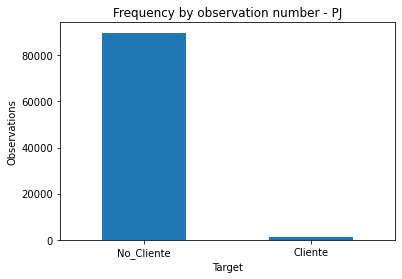

In [14]:
count_classes = pd.value_counts(final_df.loc[final_df['TIPOUSUARIO_PJ'] == 1, 'IND_CLIENTE'], sort = True)
count_classes.plot(kind = 'bar', rot = 0)
plt.xticks(range(2), LABELS)
plt.title("Frequency by observation number - PJ")
plt.xlabel("Target")
plt.ylabel("Observations");

In [15]:
print('Los clientes suponen un % del total de PJ: ', (1308/final_df.loc[final_df['TIPOUSUARIO_PJ'] == 1].shape[0])*100)

Los clientes suponen un % del total de PJ:  1.4371573291727555


------------------

------------------

### 4. Creación del Modelo - Personas Físicas

#### 4.1 Dividimos el set entre features y label

In [16]:
final_df_PF = final_df.loc[final_df['TIPOUSUARIO_PJ'] == 1]

In [17]:
features = final_df_PF[columnas]
labels = final_df_PF['IND_CLIENTE']

In [18]:
features.shape

(91013, 77)

In [19]:
labels.shape

(91013,)

------------------

#### 4.2 Creamos set de entrenamiento y test

In [20]:
train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size = 0.3, random_state = 123)

In [21]:
train_x.shape

(63709, 77)

In [22]:
test_x.shape

(27304, 77)

In [23]:
train_y.shape

(63709,)

In [24]:
test_y.shape

(27304,)

------------------

#### 4.3 Selección Hiperparámetros

Definimos una serie de hiperparámetros diferentes para comparar resultados

In [25]:
param_grid = ParameterGrid({'n_estimators': [5, 20, 50, 100, 150],
                            'max_features': [5, 'log2', 'auto', 'sqrt'],
                            'max_depth'   : [None, 3, 5, 7, 10],
                            'criterion'   : ['gini', 'entropy'],
                            'class_weight': ['balanced']
                           })

Loop para ajustar un modelo con cada combinación de hiperparámetros

In [26]:
resultados = {'params': [], 'oob_accuracy': []}

In [27]:
for params in param_grid:
    
    modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(train_x, train_y)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

Modelo: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 5} ✓
Modelo: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 20} ✓
Modelo: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 50} ✓
Modelo: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 100} ✓
Modelo: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 5} ✓
Modelo: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 20} ✓
Modelo: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 50} ✓
Modelo: {'class_weight': 'balanced', 'cri

In [28]:
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados.head(4)

,oob_accuracy,class_weight,criterion,max_depth,max_features,n_estimators
114,0.985842,balanced,entropy,NaN,auto,150
119,0.985842,balanced,entropy,NaN,sqrt,150
2,0.985779,balanced,gini,NaN,5,50
109,0.985748,balanced,entropy,NaN,log2,150


**Seleccionamos los mejores hiperparámetros**

In [29]:
print("Mejores hiperparámetros encontrados (oob-accuracy)")
print('--------------------------------------------------')
print("Estimators: \n", resultados.iloc[0,:], "accuracy")

Mejores hiperparámetros encontrados (oob-accuracy)
--------------------------------------------------
Estimators: 
 oob_accuracy    0.985842
class_weight    balanced
criterion        entropy
max_depth            NaN
max_features        auto
n_estimators         150
Name: 114, dtype: object accuracy


--------------

--------------

#### 4.4 Modelo 1 - Baseline

Nuestro modelo Base, tendrá los parámetros obtenidos como mejores anteriormente.

**Aplicamos los mejores hiperparámetros obtenidos**

In [30]:
rf = RandomForestClassifier(criterion = 'entropy', 
                            n_estimators = 150, 
                            max_features = 'auto', 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(train_x, train_y)

RandomForestClassifier(criterion='entropy', n_estimators=150, n_jobs=-1,
                       random_state=123)

Observamos los resultados del modelo

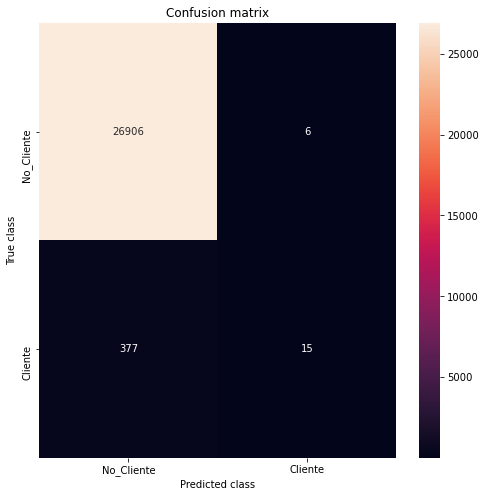

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     26912
           1       0.71      0.04      0.07       392

    accuracy                           0.99     27304
   macro avg       0.85      0.52      0.53     27304
weighted avg       0.98      0.99      0.98     27304



In [31]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [32]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [33]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
CANAL_REGISTRO,8.457007
IPCASOS,7.280383
FECHACONSUMO_MONTH,6.849277
FECHA_REGISTRO_MONTH,6.679758
FECHA_REGISTRO_WEEKDAY,5.044742
FECHACONSUMO_WEEKDAY,5.003389
1A_EMPCONSUL_PROV_IDH,4.074702
USU_DEPART_IDH,4.061166
1A_EMPCONSUL_PROV_DENS,4.039397
USU_DEPART_DEN_POB,4.018398


In [34]:
feature_importances[feature_importances['important'] > 0.01].shape

(29, 1)

------

------

------

#### 4.5 Modelo - Aplicando técnicas sobre el desbalanceo

**Estrategias para el manejo de Datos Desbalanceados**

##### **4.5.1 Penalización para compensar**

In [35]:
rf = RandomForestClassifier(criterion = 'entropy', 
                            n_estimators = 150, 
                            max_features = 'auto', 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123,
                            class_weight = 'balanced')

rf.fit(train_x, train_y)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=150, n_jobs=-1, random_state=123)

Observamos los resultados del modelo

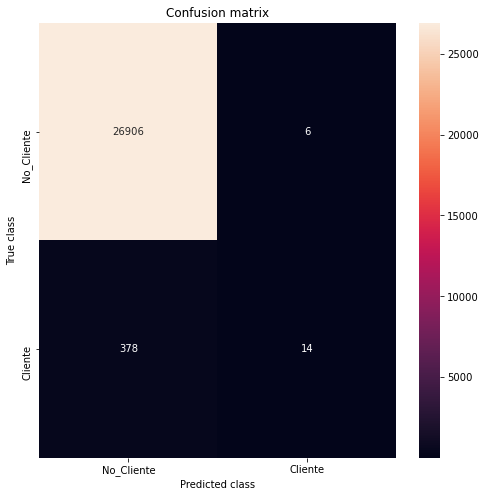

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     26912
           1       0.70      0.04      0.07       392

    accuracy                           0.99     27304
   macro avg       0.84      0.52      0.53     27304
weighted avg       0.98      0.99      0.98     27304



In [36]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [37]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [38]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
CANAL_REGISTRO,8.267353
IPCASOS,6.698110
FECHACONSUMO_MONTH,6.090512
FECHA_REGISTRO_MONTH,5.918983
USU_DEPART_DEN_POB,4.706933
FECHACONSUMO_WEEKDAY,4.475697
USU_DEPART_IDH,4.472480
FECHA_REGISTRO_WEEKDAY,4.458411
1A_EMPCONSUL_PROV_IDH,4.314082
1A_EMPCONSUL_PROV_DENS,4.277158


In [39]:
feature_importances[feature_importances['important'] > 0.01].shape

(28, 1)

------

##### **4.5.2 Subsampling en la clase mayoritaria**

**RandomUnderSampler**

In [40]:
us = RandomUnderSampler(sampling_strategy = 'majority', random_state = 123)
X_train_res, y_train_res = us.fit_resample(train_x, train_y)
 
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 62793, 1: 916})
Distribution after resampling Counter({0: 916, 1: 916})


In [41]:
rf = RandomForestClassifier(criterion = 'entropy', 
                            n_estimators = 150, 
                            max_features = 'auto', 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(criterion='entropy', n_estimators=150, n_jobs=-1,
                       random_state=123)

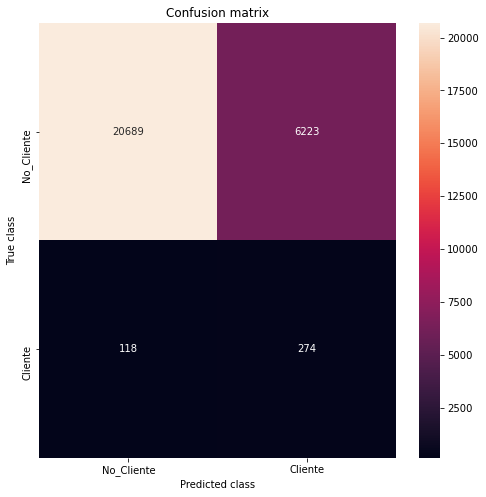

              precision    recall  f1-score   support

           0       0.99      0.77      0.87     26912
           1       0.04      0.70      0.08       392

    accuracy                           0.77     27304
   macro avg       0.52      0.73      0.47     27304
weighted avg       0.98      0.77      0.86     27304



In [42]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [43]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [44]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
CANAL_REGISTRO,7.890727
IPCASOS,6.122164
FECHACONSUMO_MONTH,5.927945
FECHA_REGISTRO_MONTH,5.609257
USU_DEPART_IDH,4.846220
USU_DEPART_DEN_POB,4.591398
FECHA_REGISTRO_WEEKDAY,4.529437
1A_EMPCONSUL_PROV_DENS,4.449271
1A_EMPCONSUL_PROV_IDH,4.379074
FECHACONSUMO_WEEKDAY,4.148372


In [45]:
feature_importances[feature_importances['important'] > 0.01].shape

(29, 1)

------

**NearMiss**

In [46]:
us = NearMiss(sampling_strategy = 'majority', n_neighbors = 2, n_jobs = -1)
X_train_res, y_train_res = us.fit_resample(train_x, train_y)
 
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 62793, 1: 916})
Distribution after resampling Counter({0: 916, 1: 916})


In [47]:
rf = RandomForestClassifier(criterion = 'entropy', 
                            n_estimators = 150, 
                            max_features = 'auto', 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(criterion='entropy', n_estimators=150, n_jobs=-1,
                       random_state=123)

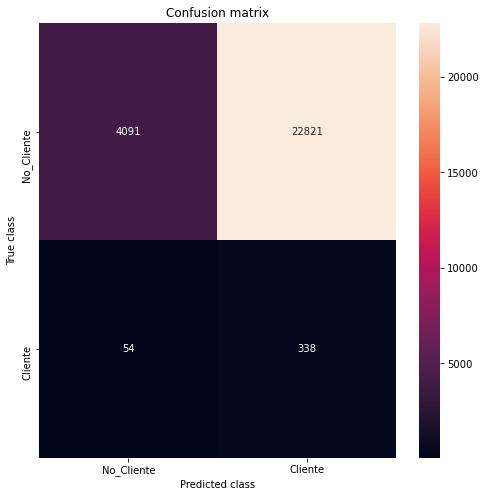

              precision    recall  f1-score   support

           0       0.99      0.15      0.26     26912
           1       0.01      0.86      0.03       392

    accuracy                           0.16     27304
   macro avg       0.50      0.51      0.15     27304
weighted avg       0.97      0.16      0.26     27304



In [48]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [49]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [50]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
IPCASOS,11.021211
CANAL_REGISTRO,7.091344
1A_EMPCONSUL_PROV_DENS,6.583632
USU_DEPART_DEN_POB,6.295640
USU_DEPART_IDH,5.858585
1A_EMPCONSUL_PROV_IDH,5.622000
1A_DESCGRUPOPROD_PERF_PROMO,4.570703
FECHA_REGISTRO_MONTH,4.231809
1A_DESCGRUPOPROD_FICH_PROMO,4.184572
FECHACONSUMO_MONTH,3.990355


In [51]:
feature_importances[feature_importances['important'] > 0.01].shape

(25, 1)

------

------

##### **4.5.3 Oversampling en la clase minoritaria**

**SMOTE**

In [52]:
os =  SMOTE(sampling_strategy = 'minority')
X_train_res, y_train_res = os.fit_resample(train_x, train_y)

In [53]:
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 62793, 1: 916})
Distribution labels after resampling Counter({0: 62793, 1: 62793})


In [54]:
rf = RandomForestClassifier(criterion = 'entropy', 
                            n_estimators = 150, 
                            max_features = 'auto', 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(criterion='entropy', n_estimators=150, n_jobs=-1,
                       random_state=123)

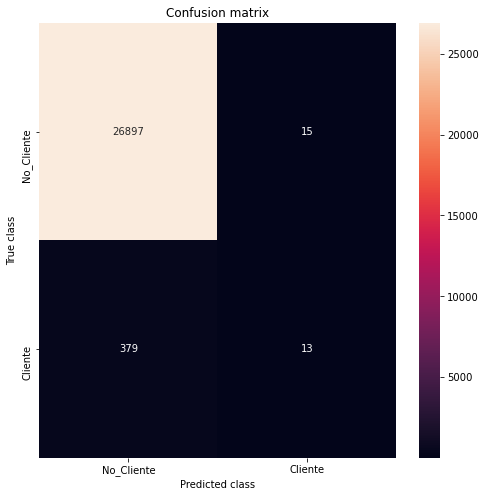

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     26912
           1       0.46      0.03      0.06       392

    accuracy                           0.99     27304
   macro avg       0.73      0.52      0.53     27304
weighted avg       0.98      0.99      0.98     27304



In [55]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [56]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [57]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
1A_DESCGRUPOPROD_PERF_PROMO,7.015014
USU_TIPO_EMPRESARIO INDIVIDUAL,6.693351
USU_TAMANIO_MC,5.981373
CANAL_REGISTRO,3.681763
TIPOEMAIL_GOOHOTYAHMAIL,3.200817
USU_SECTOR_ECONOMICO_TERCIARIO,3.008340
EMAIL_PERSONAL,2.969978
TIPO_TELF_NO_PUBLICO,2.961879
TIPO_TELF_EXTRANJERO,2.945589
TIPOEMAIL_CORPORATIVO,2.840066


In [58]:
feature_importances[feature_importances['important'] > 0.01].shape

(34, 1)

------

**RandomOverSampler**

In [59]:
os =  RandomOverSampler(sampling_strategy = 'minority')
X_train_res, y_train_res = os.fit_resample(train_x, train_y)

In [60]:
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 62793, 1: 916})
Distribution labels after resampling Counter({0: 62793, 1: 62793})


In [61]:
rf = RandomForestClassifier(criterion = 'entropy', 
                            n_estimators = 150, 
                            max_features = 'auto', 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(criterion='entropy', n_estimators=150, n_jobs=-1,
                       random_state=123)

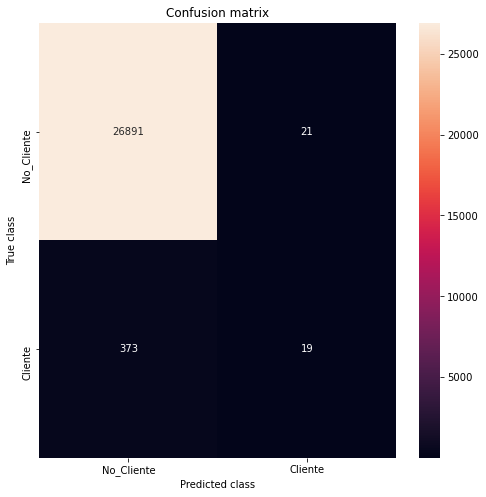

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     26912
           1       0.47      0.05      0.09       392

    accuracy                           0.99     27304
   macro avg       0.73      0.52      0.54     27304
weighted avg       0.98      0.99      0.98     27304



In [62]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [63]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [64]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
CANAL_REGISTRO,8.118135
IPCASOS,6.762000
FECHA_REGISTRO_MONTH,6.240010
FECHACONSUMO_MONTH,6.211004
FECHA_REGISTRO_WEEKDAY,4.578410
USU_DEPART_IDH,4.565319
FECHACONSUMO_WEEKDAY,4.504521
1A_EMPCONSUL_PROV_IDH,4.490803
USU_DEPART_DEN_POB,4.468302
1A_EMPCONSUL_PROV_DENS,4.275540


In [65]:
feature_importances[feature_importances['important'] > 0.01].shape

(26, 1)

------

------

##### **4.5.4 Combinamos OverSampling con Subsampling**

**Combinando SMOTE & RandomUnderSampler**

In [66]:
over = SMOTE(sampling_strategy = 0.3)
under = RandomUnderSampler(sampling_strategy = 0.5)
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps = steps)

In [67]:
X_train_res, y_train_res = pipeline.fit_resample(train_x, train_y)

In [68]:
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 62793, 1: 916})
Distribution after resampling Counter({0: 37674, 1: 18837})


In [69]:
rf = RandomForestClassifier(criterion = 'entropy', 
                            n_estimators = 150, 
                            max_features = 'auto', 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(criterion='entropy', n_estimators=150, n_jobs=-1,
                       random_state=123)

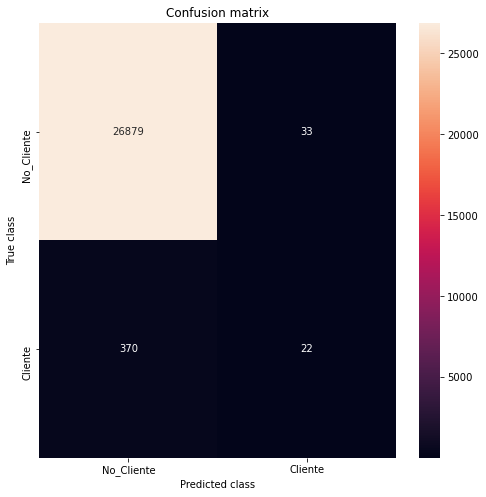

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     26912
           1       0.40      0.06      0.10       392

    accuracy                           0.99     27304
   macro avg       0.69      0.53      0.55     27304
weighted avg       0.98      0.99      0.98     27304



In [70]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [71]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [72]:
feature_importances[feature_importances['important'] > 0.01] * 100

,important
1A_DESCGRUPOPROD_PERF_PROMO,7.122014
USU_TIPO_EMPRESARIO INDIVIDUAL,5.717319
USU_TAMANIO_MC,5.591685
CANAL_REGISTRO,4.213548
EMAIL_PERSONAL,3.086240
TIPOEMAIL_GOOHOTYAHMAIL,2.939716
IPCASOS,2.869683
TIPOEMAIL_CORPORATIVO,2.859682
TIPO_TELF_EXTRANJERO,2.712603
USU_SECTOR_ECONOMICO_TERCIARIO,2.665144


In [73]:
feature_importances[feature_importances['important'] > 0.01].shape

(36, 1)

------

**Combinando SMOTE & NearMiss**

In [74]:
over = SMOTE(sampling_strategy = 'all')
under = NearMiss(sampling_strategy = 'majority', n_neighbors = 2, n_jobs = -1)
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps = steps)

In [75]:
X_train_res, y_train_res = pipeline.fit_resample(train_x, train_y)

In [76]:
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 62793, 1: 916})
Distribution after resampling Counter({0: 62793, 1: 62793})


In [77]:
rf = RandomForestClassifier(criterion = 'entropy', 
                            n_estimators = 150, 
                            max_features = 'auto', 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(criterion='entropy', n_estimators=150, n_jobs=-1,
                       random_state=123)

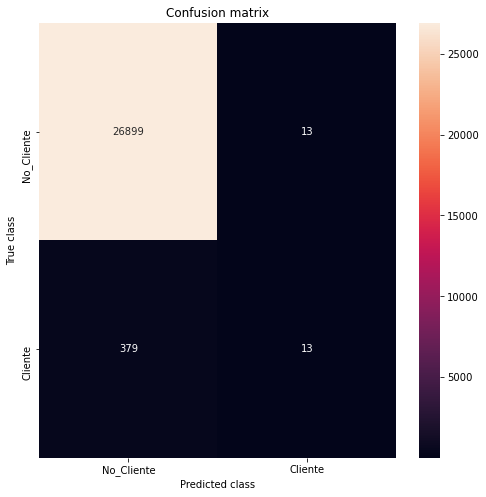

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     26912
           1       0.50      0.03      0.06       392

    accuracy                           0.99     27304
   macro avg       0.74      0.52      0.53     27304
weighted avg       0.98      0.99      0.98     27304



In [78]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [79]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [80]:
feature_importances[feature_importances['important'] > 0.01] * 100

,important
1A_DESCGRUPOPROD_PERF_PROMO,6.632129
USU_TIPO_EMPRESARIO INDIVIDUAL,6.315846
USU_TAMANIO_MC,6.155404
CANAL_REGISTRO,3.815653
EMAIL_PERSONAL,3.411406
USU_SECTOR_ECONOMICO_TERCIARIO,3.045635
TIPOEMAIL_CORPORATIVO,2.958135
TIPO_TELF_EXTRANJERO,2.906908
TIPOEMAIL_GOOHOTYAHMAIL,2.792930
TIPO_TELF_NO_PUBLICO,2.495606


In [81]:
feature_importances[feature_importances['important'] > 0.01].shape

(36, 1)

------

**SMOTETomek**

In [82]:
os_us = SMOTETomek(sampling_strategy = 'all')
X_train_res, y_train_res = os_us.fit_resample(train_x, train_y)

In [83]:
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 62793, 1: 916})
Distribution after resampling Counter({0: 62763, 1: 62763})


In [84]:
rf = RandomForestClassifier(criterion = 'entropy', 
                            n_estimators = 150, 
                            max_features = 'auto', 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(criterion='entropy', n_estimators=150, n_jobs=-1,
                       random_state=123)

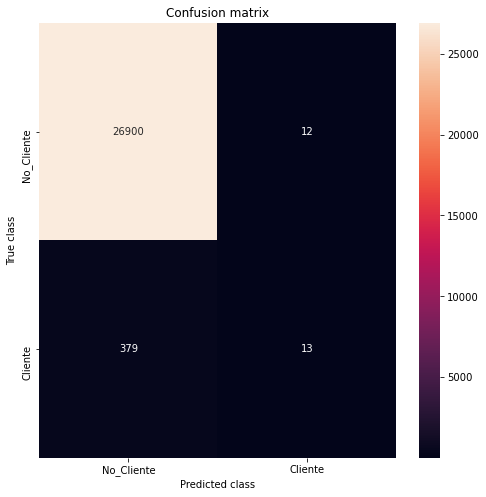

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     26912
           1       0.52      0.03      0.06       392

    accuracy                           0.99     27304
   macro avg       0.75      0.52      0.53     27304
weighted avg       0.98      0.99      0.98     27304



In [85]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [86]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [87]:
feature_importances[feature_importances['important'] > 0.01] * 100

,important
USU_TIPO_EMPRESARIO INDIVIDUAL,6.643957
1A_DESCGRUPOPROD_PERF_PROMO,6.407175
USU_TAMANIO_MC,5.950251
CANAL_REGISTRO,3.707598
TIPOEMAIL_GOOHOTYAHMAIL,3.234385
EMAIL_PERSONAL,3.206965
TIPO_TELF_NO_PUBLICO,2.849775
USU_SECTOR_ECONOMICO_TERCIARIO,2.837348
TIPO_TELF_EXTRANJERO,2.828057
TIPOEMAIL_CORPORATIVO,2.715113


In [88]:
feature_importances[feature_importances['important'] > 0.01].shape

(36, 1)

------

------

##### **4.5.5 Ensamble de Modelos con Balanceo**

Para esta estrategia usaremos un Clasificador de Ensamble que utiliza Bagging y el modelo será un RandomForest.

**Bagging**

In [89]:
bbc = BalancedBaggingClassifier(base_estimator = RandomForestClassifier(criterion = 'entropy', 
                                                                        n_estimators = 150, 
                                                                        max_features = 'auto', 
                                                                        max_depth = None, 
                                                                        n_jobs = -1,
                                                                        random_state = 123),
                                sampling_strategy = 'majority',
                                n_estimators = 20,
                                replacement = False,
                                random_state = 123)

bbc.fit(train_x, train_y)

BalancedBaggingClassifier(base_estimator=RandomForestClassifier(criterion='entropy',
                                                                n_estimators=150,
                                                                n_jobs=-1,
                                                                random_state=123),
                          n_estimators=20, random_state=123,
                          sampling_strategy='majority')

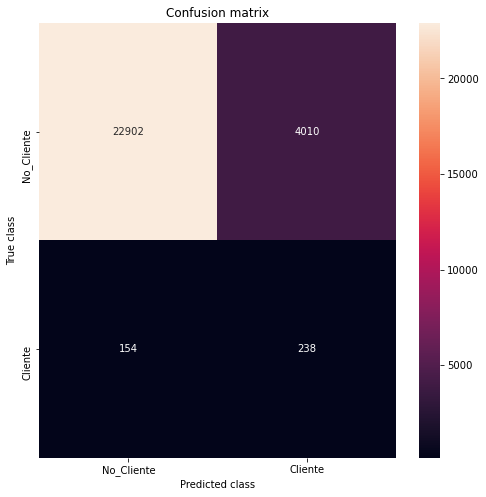

              precision    recall  f1-score   support

           0       0.99      0.85      0.92     26912
           1       0.06      0.61      0.10       392

    accuracy                           0.85     27304
   macro avg       0.52      0.73      0.51     27304
weighted avg       0.98      0.85      0.90     27304



In [90]:
pred_y = bbc.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [91]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [92]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
USU_TIPO_EMPRESARIO INDIVIDUAL,6.643957
1A_DESCGRUPOPROD_PERF_PROMO,6.407175
USU_TAMANIO_MC,5.950251
CANAL_REGISTRO,3.707598
TIPOEMAIL_GOOHOTYAHMAIL,3.234385
EMAIL_PERSONAL,3.206965
TIPO_TELF_NO_PUBLICO,2.849775
USU_SECTOR_ECONOMICO_TERCIARIO,2.837348
TIPO_TELF_EXTRANJERO,2.828057
TIPOEMAIL_CORPORATIVO,2.715113


In [93]:
feature_importances[feature_importances['important'] > 0.01].shape

(36, 1)

------

**BalancedRandomForestClassifier**

In [94]:
brfc = BalancedRandomForestClassifier(criterion = 'entropy', 
                                    n_estimators = 150, 
                                    max_features = 'auto', 
                                    max_depth = None, 
                                    sampling_strategy = 'auto',
                                    n_jobs = -1,
                                    random_state = 123)

brfc.fit(train_x, train_y)

BalancedRandomForestClassifier(criterion='entropy', n_estimators=150, n_jobs=-1,
                               random_state=123)

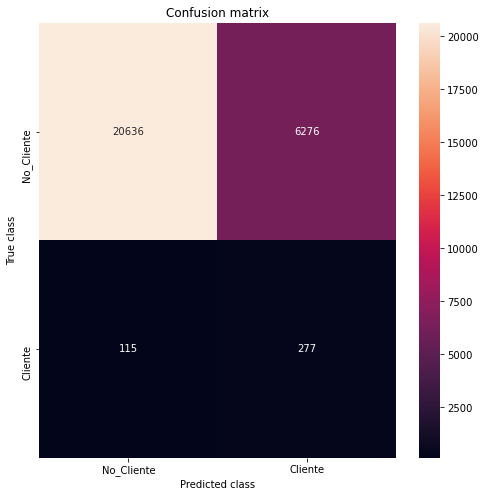

              precision    recall  f1-score   support

           0       0.99      0.77      0.87     26912
           1       0.04      0.71      0.08       392

    accuracy                           0.77     27304
   macro avg       0.52      0.74      0.47     27304
weighted avg       0.98      0.77      0.85     27304



In [95]:
pred_y = brfc.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [96]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [97]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
USU_TIPO_EMPRESARIO INDIVIDUAL,6.643957
1A_DESCGRUPOPROD_PERF_PROMO,6.407175
USU_TAMANIO_MC,5.950251
CANAL_REGISTRO,3.707598
TIPOEMAIL_GOOHOTYAHMAIL,3.234385
EMAIL_PERSONAL,3.206965
TIPO_TELF_NO_PUBLICO,2.849775
USU_SECTOR_ECONOMICO_TERCIARIO,2.837348
TIPO_TELF_EXTRANJERO,2.828057
TIPOEMAIL_CORPORATIVO,2.715113


In [98]:
feature_importances[feature_importances['important'] > 0.01].shape

(36, 1)

------

**RUSBoostClassifier**

In [99]:
RUS = RUSBoostClassifier(base_estimator = RandomForestClassifier(criterion = 'entropy', 
                                                                        n_estimators = 150, 
                                                                        max_features = 'auto', 
                                                                        max_depth = None, 
                                                                        n_jobs = -1,
                                                                        random_state = 123),
                                sampling_strategy = 'majority',
                                n_estimators = 20,
                                replacement = False,
                                random_state = 123)

RUS.fit(train_x, train_y)

RUSBoostClassifier(base_estimator=RandomForestClassifier(criterion='entropy',
                                                         n_estimators=150,
                                                         n_jobs=-1,
                                                         random_state=123),
                   n_estimators=20, random_state=123,
                   sampling_strategy='majority')

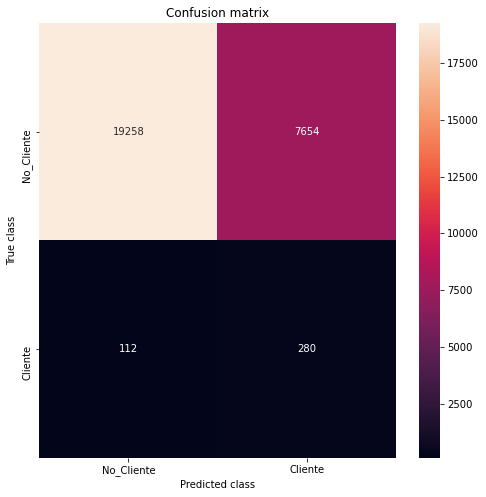

              precision    recall  f1-score   support

           0       0.99      0.72      0.83     26912
           1       0.04      0.71      0.07       392

    accuracy                           0.72     27304
   macro avg       0.51      0.71      0.45     27304
weighted avg       0.98      0.72      0.82     27304



In [100]:
pred_y = RUS.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [101]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [102]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
USU_TIPO_EMPRESARIO INDIVIDUAL,6.643957
1A_DESCGRUPOPROD_PERF_PROMO,6.407175
USU_TAMANIO_MC,5.950251
CANAL_REGISTRO,3.707598
TIPOEMAIL_GOOHOTYAHMAIL,3.234385
EMAIL_PERSONAL,3.206965
TIPO_TELF_NO_PUBLICO,2.849775
USU_SECTOR_ECONOMICO_TERCIARIO,2.837348
TIPO_TELF_EXTRANJERO,2.828057
TIPOEMAIL_CORPORATIVO,2.715113


In [103]:
feature_importances[feature_importances['important'] > 0.01].shape

(36, 1)

---------------

**EasyEnsembleClassifier**

In [104]:
Easy = EasyEnsembleClassifier(sampling_strategy = 'majority',
                              n_estimators = 150,
                              replacement = False,
                              random_state = 123)

Easy.fit(train_x, train_y)

EasyEnsembleClassifier(n_estimators=150, random_state=123,
                       sampling_strategy='majority')

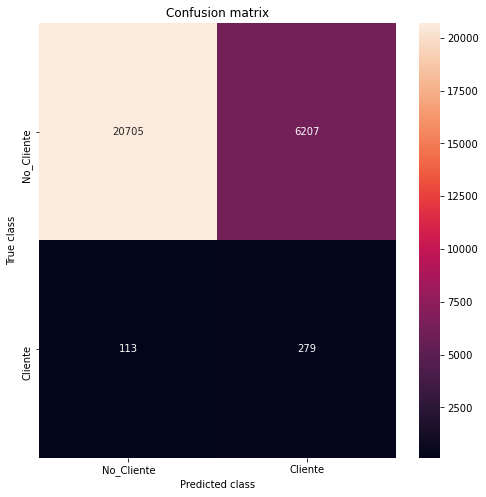

              precision    recall  f1-score   support

           0       0.99      0.77      0.87     26912
           1       0.04      0.71      0.08       392

    accuracy                           0.77     27304
   macro avg       0.52      0.74      0.47     27304
weighted avg       0.98      0.77      0.86     27304



In [105]:
pred_y = Easy.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [106]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [107]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
USU_TIPO_EMPRESARIO INDIVIDUAL,6.643957
1A_DESCGRUPOPROD_PERF_PROMO,6.407175
USU_TAMANIO_MC,5.950251
CANAL_REGISTRO,3.707598
TIPOEMAIL_GOOHOTYAHMAIL,3.234385
EMAIL_PERSONAL,3.206965
TIPO_TELF_NO_PUBLICO,2.849775
USU_SECTOR_ECONOMICO_TERCIARIO,2.837348
TIPO_TELF_EXTRANJERO,2.828057
TIPOEMAIL_CORPORATIVO,2.715113


In [108]:
feature_importances[feature_importances['important'] > 0.01].shape

(36, 1)

---------------

---------------

---------------

# CONCLUSIONES

Realizaremos un modleo base sobre el que comparar los resultados. 

| Modelo | Accuracy  | NoClientes - Precision  | NoClientes - Recall  | Clientes - Precision | Clientes - Recall | # Variables utilizadas
|---|:---:|:---:|:---:|:---:|:---:|:---:|
| Baseline | 0.99 | 0.99 | 1.00 |  0.71 | 0.04 | 29 |

### **Resultados** 

| Modelo |Tecnica |Algoritmo   | Accuracy  | NoClientes - Precision  | NoClientes - Recall  | Clientes - Precision | Clientes - Recall | # Variables utilizadas
|---|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| Modelo 1 | **Penalización para compensar** | | 0.99 | 0.99 | 1.00 | 0.70 | 0.04 | 28 |
| Modelo 2 | **Subsampling en la clase mayoritaria** | RandomUnderSampler | 0.77 | 0.99 | 0.77 | 0.04 | 0.70 | 29 |
| Modelo 3 | **Subsampling en la clase mayoritaria** | NearMiss| 0.16 | 0.99 | 0.15 | 0.01 | 0.86 | 25 |
| Modelo 4 | **Oversampling en la clase minoritaria** | SMOTE| 0.99 | 0.99 | 1.00 | 0.46 | 0.03 | 34 |
| Modelo 5 | **Oversampling en la clase minoritaria** | RandomOverSampler| 0.99 | 0.99 | 1.00 | 0.47 | 0.05 | 26 |
| Modelo 6 | **Combinamos OverSampling con Subsampling** | SMOTE & RandomUnderSampler | 0.99 | 0.99 | 1.00 | 0.40 | 0.06 | 36 |
| Modelo 7 | **Combinamos OverSampling con Subsampling** | SMOTE & NearMiss | 0.99 | 0.99 | 1.00 | 0.50 | 0.03 | 36 |
| Modelo 8 | **Combinamos OverSampling con Subsampling** | SMOTE-Tomek| 0.99 | 0.99 | 1.00 | 0.52 | 0.03 | 36 |
| Modelo 9 | **Ensamble de Modelos con Balanceo** | BalancedBaggingClassifier| 0.85 | 0.99 | 0.85 | 0.06 | 0.61 | 36 |
| Modelo 10 | **Ensamble de Modelos con Balanceo** | BalancedRandomForestClassifier| 0.77 | 0.99 | 0.77 | 0.04 | 0.71 | 36 |
| Modelo 11 | **Ensamble de Modelos con Balanceo** | RUSBoostClassifier| 0.72 | 0.99 | 0.72 | 0.04 | 0.71 | 36 |
| Modelo 12 | **Ensamble de Modelos con Balanceo** | EasyEnsembleClassifier| 0.77 | 0.99 | 0.77 | 0.04 | 0.71 | 36 |

Tras los resultados obtenidos y expuestos, podemos concluir que la técnica que mejores resultados nos ha proporcionado es **El Ensamble de modelos con balanceo**, en concreto el algoritmo seleccionado hay 2 modelos que presentan resultados más aceptables como son **EasyEnsembleClassifier** y **BalancedRandomForestClassifier** que a pesar de ser un algoritmo con poco accuracy en comparación con el resto, tienen una **precision de la clase de clientes peor que otros casos**, lo que nos centramos es en la métrica de recall, tanto en la clase minoritaria como mayoritaria, ya que como podemos comprobar, la técnica **NearMis** Tiene un muy buen recall de la clase clientes pero pésima de la clase no clietnes.

Las técnicas que más equilibrio presentan en la métrica de recall son las técnicas **BalancedRandomForestClassifier** y **EasyEnsembleClassifier**. 